<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [1]:
#| default_exp svm

In [2]:
#|hide
# autoreload
%load_ext autoreload
%autoreload 2
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
# 设置matplotlib支持中文显示
# 参考网上资料，说要设为 SimHei
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体  
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
# 但是SimHei这个linux上不存在，好像是微软的字体，不开源。
# 参考另一篇博客解决这个问题 https://blog.csdn.net/MAO_TOU/article/details/93998905
from matplotlib import font_manager
font = font_manager.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams['font.sans-serif'] = [font.get_name()]
# proxy
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

## 代码与文档格式说明

本文档使用Jupyter Notebook编写，所以同时包括了实验文档和实验代码。

本次实验项目采用了 Quarto + nbdev 的系统来发布Jupyter Notebook, 因而我们的实验文档导出为pdf和html格式可以进行阅读，而我们的代码也导出为python模块形式，可以作为代码库被其他项目使用。

我们这样做的好处是，避免单独管理一堆 .py 文件，防止代码冗余和同步混乱，py文件和pdf文件都是从.ipynb文件导出的，可以保证实验文档和代码的一致性。

::: {.callout-important}
可以通过以下命令安装我们实验的代码：

```shell
pip install git+https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git
```
我们的代码导出为了python模块形式，通过以下命令导入：
```python
from thu_big_data_ml.svm import *
```
:::

https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git 是本次实验的代码仓库地址，
而这次作业中，我开发的另一个用于科研的开源项目[有名的分类框架 (NamableClassify)](https://github.com/2catycm/NamableClassify.git)也相应地进行了代码更新，把我们这次作业实现的SVM算法加入到了其中。接下来我们也会用到这个项目中的一些代码来完成本次作业。
```shell
pip install git+https://github.com/2catycm/NamableClassify.git
```

```python
from namable_classify import *
```

::: {.callout-important}
本文档具有一定的交互性，建议使用浏览器打开html文件，这样比pdf文件阅读体验更佳。
:::

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()

## 实验目的
> 老师给我们的要求是
> 1. ⼿动实现一个 SVM 分类器，完成 MNIST 数据分类任务
>
> 2. 掌握 SVM 的基本原理以及优化流程
>
> 3. 对 SVM 分类器训练的超参数(包括收敛终止条件，学习率等)进行调优
>


~~作为Top1大学的学生~~，我们不仅需要完成以上内容，还需要进行一些深入的思考和探索。
1. 现有最流行的SVM分类的实现是sklearn以及其背后的libsvm，由于C++编写，确实在CPU上运行很快。但是，如果我们需要在GPU上运行，是否可以考虑用CUDA来加速呢？我们决定尝试一下实现速度更快的SVM分类器。
2. sklearn自带的调参GridSearchCV和RandomizedSearchCV都具有一定的局限性。参考谷歌调参手册，我们使用科学的实验设计来对SVM分类算法的元参数进行搜索，从而实现更高的分类精度，并且获得一些insight，便于我们后续科研中使用SVM。
3. 实现自己的kernel方法。实现之后，不仅像2那样参考谷歌调参手册和假设检验来比较数值上的性能，还使用可视化工具来对不同核函数的效果进行比较。
4. 参考前沿论文，探索一些更加新的SVM策略。


事不宜迟，我们开始动手吧！

## 实验数据
> MNIST 数据库是由 Yann et. al. 提供的⼿写数字数据库⽂件, 官网地址为 http://yann.lecun.com/exdb/mnist/。
> 主要包含了 60000 张的训练图像和 10000 张的测试图像

类似于上一次Project（KD树实现KNN），我们使用 sklearn CI（持续集成）测试用例的load_digits数据集，而不是使用原始的MNIST数据集，来加快实验的效率。并且在划分数据集时，train_test_split应当使用stratify参数，以确保每一类样本的比例相同。

In [4]:
#| hide
# from namable_classify.data import ClassificationDataConfig, ClassificationDataModule, MNISTDataModule
# # ClassificationDataConfig?
# mnist_data = MNISTDataModule.from_config(ClassificationDataConfig(dataset_name='MNIST'))
# mnist_data.prepare_data()
# mnist_data.hparams

In [5]:
from namable_classify.utils import logger, print
from sklearn.datasets import load_digits, fetch_openml
# dataset_dict_uci_digits = load_digits(as_frame=True)
dataset_dict_uci_digits = load_digits(as_frame=False)
dataset_dict_full_mnist = fetch_openml("mnist_784", as_frame=True)
dataset_dict_uci_digits.keys(), dataset_dict_full_mnist.keys()


(
    dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']),
    dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
)

In [6]:
dataset_dict_uci_digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
#| export
import pandas as pd
import numpy as np
def sklearn_to_X_y_categories(dataset_dict):
    X = dataset_dict['data']
    y = dataset_dict['target']
    if isinstance(X, pd.DataFrame):
        X:np.array = X.values
    if isinstance(y, pd.Series):
        y:np.array = y.values
    # if y.dtype.name == 'category':
    #     categories = y.dtype.categories
    # else:
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    categories = np.unique(y)
    # print(str((X.shape, X.dtype, y.shape, y.dtype, categories)))
    print(X.shape, X.dtype, y.shape, y.dtype, categories)
    return X, y, categories


In [8]:
X, y, categories = sklearn_to_X_y_categories(dataset_dict_uci_digits)
X_full, y_full, categories_full = sklearn_to_X_y_categories(dataset_dict_full_mnist)

Thu 2024-11-14 15:37:27.516579

INFO     ((1797, 64), dtype('float32'), (1797,), dtype('int64'), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])) ]8;id=744489;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=118429;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#79\79]8;;\

Thu 2024-11-14 15:37:27.719045

INFO     ((70000, 784), dtype('float32'), (70000,), dtype('int64'), array([0, 1, 2, 3, 4, 5, 6, 7, 8,   ]8;id=871088;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=221855;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#79\79]8;;\
         9]))                                                                                                      

划分数据集为训练集和测试集。
注意这里与官方的mnist划分有所不同，但是是合理而且科学的，因为正确使用了`stratify`参数。

In [12]:
#| export
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def make_train_val_test(X, y, val_size=0.1, test_size=0.2, random_state=42, normalize=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                        stratify=y)
    # print(len(X_train), len(X_test))
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    # 进一步划分出验证集，用于调参、early stopping等。
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, 
                                                    stratify=y_train)
    print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test, y_train, y_val, y_test


In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(X, y)
X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full = make_train_val_test(X_full, y_full)

Thu 2024-11-14 15:41:19.719548

INFO     (1293, 144, 360)                                                                               ]8;id=543630;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=289865;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#79\79]8;;\

Thu 2024-11-14 15:41:23.278243

INFO     (50400, 5600, 14000)                                                                           ]8;id=573876;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=448748;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#79\79]8;;\

获得 PyTorch 格式 的Dataset，
进一步得到 PyTorch Lightning 的 DataModule

In [ ]:
#| export
import torch
import lightning as L
def get_torch_dataset(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    return dataset

In [15]:
train_set = get_torch_dataset(X_train, y_train)
val_set = get_torch_dataset(X_val, y_val)
test_set = get_torch_dataset(X_test, y_test)
train_set_full = get_torch_dataset(X_train_full, y_train_full)
val_set_full = get_torch_dataset(X_val_full, y_val_full)
test_set_full = get_torch_dataset(X_test_full, y_test_full)

In [16]:
import lightning as L
data_module = L.LightningDataModule.from_datasets(
    train_dataset=train_set, 
    val_dataset=val_set, 
    test_dataset=test_set, 
    predict_dataset=test_set, 
    batch_size=128,  
    num_workers=4
)
data_module_full = L.LightningDataModule.from_datasets(
    train_dataset=train_set_full, 
    val_dataset=val_set_full, 
    test_dataset=test_set_full, 
    predict_dataset=test_set_full, 
    batch_size=128,  
    num_workers=4
)

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
#| export
from typing import Literal
ReturnType = Literal['numpy', 'torch', 'lightning', 'pandas']

def process_sklearn_dataset_dict(dataset_dict:dict, return_type:ReturnType):
    X, y, categories = sklearn_to_X_y_categories(dataset_dict)
    X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(X, y)
    train_set = get_torch_dataset(X_train, y_train)
    val_set = get_torch_dataset(X_val, y_val)
    test_set = get_torch_dataset(X_test, y_test)
    data_module = L.LightningDataModule.from_datasets(
        train_dataset=train_set, 
            val_dataset=val_set, 
            test_dataset=test_set, 
            predict_dataset=test_set, 
            batch_size=128,  
            num_workers=4
        )
    if return_type == 'numpy':
        return X_train, X_val, X_test, y_train, y_val, y_test
    elif return_type == 'torch':
        return train_set, val_set, test_set
    elif return_type == 'lightning':
        return data_module  
    elif return_type == 'pandas':
        raise NotImplementedError("Pandas not implemented yet") # 这里可以用 dataset_dict 的 frame, 但是 train test split 还有预处理。

## 理论回顾
### SVM有哪些优化形式？我们选择哪种来实现代码？


支持向量机（SVM）的优化方法主要有两种：使用hinge loss进行梯度下降和通过求解对偶问题使用SMO算法。这是两个不同形式的问题。


### SVM如何实现多分类？

李航书上介绍的SVM是用于二分类问题的，然而本次项目我们需要做MNIST手写数字分类，这需要多分类，因而我们必须了解SVM如何实现多分类。

周志华西瓜书告诉我们认为普通的二分类分类器，可以通过ovr或者ovo策略来实现多分类。那么SVM本身有没有更加独特的技巧去实现多分类呢？

我们参考这个课件 https://www.mit.edu/~rakhlin/6.883/lectures/lecture05.pdf 

目前，构造SVM多类分类器的方法主要有两类：

1. 直接法（也就是我说的独特的方法）：直接在目标函数上进行修改，将多个分类面的参数求解合并到一个最优化问题中，通过求解该最优化问题“一次性”实现多类分类。
2. 间接法（所有二分类器都可以这么操作得到多分类器）：主要是通过组合多个二分类器来实现多分类器的构造，常见的方法有one-against-one（OvO）和one-against-all（OvR）两种。具体来说，
    - 一对多法（One-Versus-Rest, OvR）：训练时依次把某个类别的样本归为一类，其他剩余的样本归为另一类，这样k个类别的样本就构造出了k个SVM。分类时将未知样本分类为具有最大分类函数值的那类。
    - 一对一法（One-Versus-One, OvO）：将n个类别两两配对，产生n(n-1)/2个二分类任务，获得n(n-1)/2个分类器，新样本交给这些分类器，得到n(n-1)/2个结果，最终结果投票产生。

### SVM如何实现概率输出？

尽管李航书第一章把SVM是归类为非概率模型，实际上SVM经过一定的操作，是可以得到概率输出的。
经典机器学习sklearn库的学习器有一个重要的API，`predict_proba()`，而sklearn中的SVC同样支持该API的调用。

那么SVM概率输出有哪些方法呢？是否要用到点和分离超平面的几何间隔呢？经过资料查询，我发现SVM的概率输出几种方法：
1. Sigmoid函数转换：可以将实轴上的数值投射到[0,1]上，即将一个输出实值抓化为一个概率值。比如一个分类器的分界线为0，大于0标为+1，小于0标为-1；如果使用sigmoid函数套一下输出值，我们就可以说，输出为0时标为+1的概率为0.5；输出为2时标为+1的概率为0.8等。
2. Platt Scaling：这是libsvm中使用的一种方法，核心思想是把分类的结果作为新的训练集，用logistics回归再训练一个关系，得到具体的概率值。
3. CalibratedClassifierCV：在scikit-learn中，可以使用专门的函数CalibratedClassifierCV对训练好的分类器模型进行校准，校准过程用到了cross-validation。
在使用predict_proba()函数时，返回的是一个n行k列的数组，第i行第j列上的数值是模型预测第i个预测样本为某个标签的概率，并且每一行的概率和为1。



### 相关工作

类似于我们这次Project的，实现SVM的代码仓库有哪些？

教育学习目的的库：
- https://github.com/Kaslanarian/libsvm-sc-reading?tab=readme-ov-file
    - 这篇文章写得非常用心，阅读libsvm源码解读地非常详细。
- https://github.com/lzx1019056432/Be-Friendly-To-New-People/tree/master/SVM%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%9C%BA
    - 作者历时一个月，终于实现了SMO版本的SVM。但是我们做这个Project只有一周，我们要站在巨人的肩膀上实现地更好。
- https://github.com/Learner0x5a/SVM-SMO
    - 作者推导良久，终于搞懂了SVM以及SMO的公式，实现了符合sklearn接口的SVM。
- https://github.com/shicaiwei123/svm-smo?tab=readme-ov-file
    - 作者使用numpy实现了 SMO，并且使用ovo策略实现了多分类。
- https://github.com/kazuto1011/svm-pytorch
    - 作者使用早期版本的PyTorch实现了SVM。
- https://bytepawn.com/svm-with-pytorch.html
    - 这篇文章实现了二分类情况下，更早期PyTorch版本下实现的SVM。并且开源到github jupyter notebook。


实际部署在工业界的Python库：
- sklearn 本质上调用了 libsvm
    - 注意sklearn很长一段时间不会利用GPU优化SVM！ https://stackoverflow.com/questions/35292741/what-svm-python-modules-use-gpu
- https://pypi.org/project/svmlight/

非Python语言的库
- C++ libsvm https://github.com/cjlin1/libsvm
    - GPU升级版，基于CUDA/C++实现 https://mklab.iti.gr/results/gpu-accelerated-libsvm/
- Rust https://athemathmo.github.io/rusty-machine/doc/rusty_machine/learning/svm/index.html
- Rust https://docs.rs/linfa-svm/latest/linfa_svm/

## 实验内容

### 调库实现SVM

为了给我们后面的实验一个参照，我们调用现有代码库的SVM，关注其精度与速度的情况。
当然如果我们Project在此收尾，只能酌情被扣除分数。
在本节之后，我们将使用 PyTorch 和 numpy 这样的基础科学计算库，来在GPU和CPU上实现SVM及其优化。

::: {.callout-important}
本次Project首先展示了几个常用的SVM库的精度与速度，并且对其进行调参；随后本次Project基于基础科学计算库手写实现了SVM及其优化，和前面的库的精度与速度进行了对比。
:::


#### sklearn实现的 SMO 形式的 RBF kernel SVM

In [20]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)

SVC(probability=True)

In [21]:
from namable_classify.metrics import compute_classification_metrics
compute_classification_metrics?

Signature:
compute_classification_metrics(
    y_true: numpy.ndarray,
    y_pred_logits: numpy.ndarray = None,
    logits_to_prob: bool = False,
    y_pred: numpy.ndarray = None,
    labels: list[int | str] | None = None,
    supress_warnings: bool = True,
    y_pred_metrics_only: bool = False,
)
Docstring: <no docstring>
File:      ~/repos/novelties/cv/cls/NamableClassify/namable_classify/metrics.py
Type:      function

In [22]:
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)
svc_res = compute_classification_metrics(y_test, y_pred_proba, logits_to_prob=False, y_pred=y_pred, labels=list(range(10)))
svc_res


{
    'acc1': 0.9722222222222222,
    'acc2': 0.9833333333333333,
    'acc3': 0.9888888888888889,
    'acc5': 0.9916666666666667,
    'acc10': 1.0,
    'acc20': 1.0,
    'matthews_corrcoef': 0.9692503039897137,
    'f1': 0.972029880729665,
    'precision': 0.973182392919235,
    'recall': 0.971984126984127,
    'balanced_accuracy': 0.971984126984127,
    'cohen_kappa': 0.9691339500827382,
    'roc_auc': 0.9993491543435988,
    'hinge_loss': 0.11934175394353028,
    'log_loss': 0.12848690020890388,
    'acc1_pred': 0.9722222222222222
}

需要注意的是，SVM的概率计算的机制较为特殊，所以用SVM的概率预测值进行决策的话，与SVM本身的预测是有所不同的。
因此我们上面看到的结果中，根据`y_pred_proba`计算的`acc1`(top k 准确率) 与 根据 `y_pred`计算的`acc1`并不相同，SVM本身的预测比SVM的概率预测更加准确。

为了更好理解，我们代码可以看到具体的区别在哪里：

In [23]:
interested = np.where(np.argmax(y_pred_proba, axis=1)!=y_pred)
y_pred_proba[interested], np.argmax(y_pred_proba, axis=1)[interested], y_pred[interested]


(
    array([[0.04590906, 0.06719998, 0.01628176, 0.01364999, 0.04946972,
        0.08474905, 0.30344213, 0.02468219, 0.37951532, 0.01510081],
       [0.00597448, 0.04323558, 0.01257333, 0.04450807, 0.01366449,
        0.03308846, 0.00392504, 0.39258959, 0.01278519, 0.43765577],
       [0.13636537, 0.0167463 , 0.16969029, 0.17534658, 0.05185654,
        0.12893753, 0.13739251, 0.02586136, 0.03807921, 0.1197243 ]]),
    array([8, 9, 3]),
    array([6, 7, 2])
)

#### sklearn 实现的 SMO形式 的 linear SVM

In [24]:
from sklearn.svm import SVC
svc_linear = SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [25]:
y_pred = svc_linear.predict(X_test)
y_pred_proba = svc_linear.predict_proba(X_test)
compute_classification_metrics(y_test, y_pred_proba, logits_to_prob=False, y_pred=y_pred, labels=list(range(10)))


{
    'acc1': 0.9777777777777777,
    'acc2': 0.9972222222222222,
    'acc3': 0.9972222222222222,
    'acc5': 1.0,
    'acc10': 1.0,
    'acc20': 1.0,
    'matthews_corrcoef': 0.9723041620958817,
    'f1': 0.9748756231876998,
    'precision': 0.9756801209103841,
    'recall': 0.9748326898326898,
    'balanced_accuracy': 0.9748326898326898,
    'cohen_kappa': 0.9722207932506817,
    'roc_auc': 0.9995052178959586,
    'hinge_loss': 0.13536789001727356,
    'log_loss': 0.12285249236410403,
    'acc1_pred': 0.975
}

#### sklearn 实现的 基于 liblinear  库 的 Linear SVM

The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations.

In [26]:
n_samples, n_features = X_train.shape
sklearn_will_use_dual_problem = n_samples < n_features
n_samples, n_features, sklearn_will_use_dual_problem

(1293, 64, False)

In [27]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=sklearn_will_use_dual_problem, 
                       tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1)
linear_svc.fit(X_train, y_train)

LinearSVC(dual=False)

In [28]:
y_pred = linear_svc.predict(X_test)
compute_classification_metrics(y_test, y_pred=y_pred, labels=list(range(10)), y_pred_metrics_only=True)


{
    'matthews_corrcoef': 0.9507782171913305,
    'f1': 0.9551493507947526,
    'precision': 0.9564648995608748,
    'recall': 0.9553131703131704,
    'balanced_accuracy': 0.9553131703131704,
    'cohen_kappa': 0.9506151669738929,
    'acc1_pred': 0.9555555555555556
}

#### sklearn 实现的 SGD优化Hinge Loss形式 的 linear SVM

https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html

sklearn实现的 soft-margin linear Support Vector Machine 在 `from sklearn.linear_model import SGDClassifier`类中给出。
sklearn使用的是 one versus all (OVA) scheme，文档摘录如下
> For each of the classes, a binary classifier is learned that discriminates between that and all other classes. At testing time, we compute the confidence score (i.e. the signed distances to the hyperplane) for each classifier and choose the class with the highest confidence. 

sklearn文档指出这种形式的SVM的潜在优化，包括以下几点
- modified_huber，这是一个平滑版本的hinge loss，有研究表明效果更好。
- ASGD，这个似乎类似于深度学习中的 [Stochastic Weight Averaging (SWA)](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/)、[Model Exponential moving average (Model EMA)](https://timm.fast.ai/training_modelEMA)和[Sharpness-Aware Minimization (SAM)](https://github.com/davda54/sam)，我们有空深入研究一下这里面的区别与联系。
- Elastic Net, 结合了L1和L2的正则项，来控制模型复杂度。
- optimal learning rate, 具体来说是 Leon Bottou 提出的一种方法，公式在[此处](https://stackoverflow.com/questions/52577305/the-formula-for-the-optimal-learning-rate-in-the-sgdclassifier-in-scikit-learn)可见。

In [29]:
from sklearn.linear_model import SGDClassifier
sgd_svm = SGDClassifier(
    # loss="hinge", 
# penalty="l2", 
    loss="modified_huber", 
                    penalty="elasticnet", 
                    max_iter=1000, fit_intercept=True, 
                    learning_rate='optimal', 
                    early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, warm_start=True, average=True)
sgd_svm.fit(X_train, y_train)

SGDClassifier(average=True, early_stopping=True, loss='modified_huber',
              penalty='elasticnet', warm_start=True)

In [30]:
y_pred = sgd_svm.predict(X_test)
compute_classification_metrics(y_test, y_pred=y_pred, labels=list(range(10)), y_pred_metrics_only=True)


{
    'matthews_corrcoef': 0.9477642973566051,
    'f1': 0.9519196829960196,
    'precision': 0.9535005042857335,
    'recall': 0.9524603174603173,
    'balanced_accuracy': 0.9524603174603173,
    'cohen_kappa': 0.9475286149097613,
    'acc1_pred': 0.9527777777777777
}

#### 使用更加高性能的SVM库来加速训练

##### CPU上对SVM训练的加速
我们首先尝试CPU上的加速。针对英特尔CPU，Intel对sklearn库进行了加速，我们通过下面的方式启用
```bash
pip install scikit-learn-intelex
```
参考 [博客](https://stackoverflow.com/questions/17310752/can-you-capture-the-output-of-ipythons-magic-methods-timeit) 进行测速。

In [31]:
# 加速之前
original_sklearn = [0]*4
original_sklearn[0] = %timeit -o svc.fit(X_train, y_train)
original_sklearn[1] = %timeit -o  svc_linear.fit(X_train, y_train)
original_sklearn[2] = %timeit -o linear_svc.fit(X_train, y_train)
original_sklearn[3] = %timeit -o sgd_svm.fit(X_train, y_train)

189 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.7 ms ± 624 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
201 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.8 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
from sklearnex import patch_sklearn
patch_sklearn(verbose=False)
import logging
logging.disable(logging.INFO)
# 因为存在JIT影响，先跑一遍
svc.fit(X_train, y_train)
svc_linear.fit(X_train, y_train)
linear_svc.fit(X_train, y_train)
sgd_svm.fit(X_train, y_train)
pass

In [33]:
# 加速之后
intel_sklearn = [0]*4
intel_sklearn[0] = %timeit -o svc.fit(X_train, y_train)
intel_sklearn[1] = %timeit -o  svc_linear.fit(X_train, y_train)
intel_sklearn[2] = %timeit -o linear_svc.fit(X_train, y_train)
intel_sklearn[3] = %timeit -o sgd_svm.fit(X_train, y_train)

182 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
69.6 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
204 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
46 ms ± 872 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


[英特尔宣称](https://raw.githubusercontent.com/intel/scikit-learn-intelex/master/doc/sources/_static/scikit-learn-acceleration.PNG) 对SVC的加速可以达到203.7%，然而我们并没有看到这样的结果。
我们使用假设检验来看看英特尔的sklearn是不是显著地块？这里由于结果是相关的，而且不能假设是正态分布，所以使用 `wilcoxon` signed rank 检验。

In [34]:
original_sklearn_time = [t.best for t in original_sklearn]
intel_sklearn_time = [t.best for t in intel_sklearn]
from scipy.stats import wilcoxon
res_less = wilcoxon(intel_sklearn_time, original_sklearn_time, zero_method='zsplit',alternative='less' # 实验备则假设， intel_sklearn 用时更短
                    )
if res_less.pvalue > 0.05:
    print("Null hypothesis cannot be rejected, so I have to accept that intel_sklearn is not faster than original_sklearn. ")
res_less
res_greater = wilcoxon(intel_sklearn_time, original_sklearn_time, zero_method='zsplit', alternative='greater' # 实验备则假设，intel_sklearn 用时更长
                    )
res_less, res_greater

Thu 2024-11-14 15:49:21.054609

INFO     Null hypothesis cannot be rejected, so I have to accept that intel_sklearn is not faster than  ]8;id=534485;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=44073;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#77\77]8;;\
         original_sklearn.                                                                                         

(WilcoxonResult(statistic=2.0, pvalue=0.1875), WilcoxonResult(statistic=2.0, pvalue=0.875))

可以看出，不能显著地说哪个更快，都是在随机误差范围之内。可以认为这两个方法一样快。

##### GPU上对SVM的加速

```bash
pip install thundersvm
```

In [35]:
from thundersvm import SVC
# SVC?
from sklearn.svm import SVC
thunder_svc = SVC(kernel='rbf', probability=True)
thunder_svc.fit(X_train, y_train)

SVC(probability=True)

In [37]:
y_pred = thunder_svc.predict(X_test)
y_pred_proba = thunder_svc.predict_proba(X_test)
thunder_svc_res = compute_classification_metrics(y_test, y_pred_proba, logits_to_prob=False, y_pred=y_pred, labels=list(range(10)))
# thunder_svc_res, svc_res
res = []
for k, v in thunder_svc_res.items():
    delta = v - svc_res[k]
    # print(f"{k}: {v:.4f} ({delta:+.4f})")
    res.append(dict(metric=k, value=v, delta=delta))
import pandas as pd 
pd.DataFrame(res)

,metric,value,delta
0,acc1,0.972222,0.000000
1,acc2,0.988889,0.005556
2,acc3,0.991667,0.002778
3,acc5,0.994444,0.002778
4,acc10,1.000000,0.000000
5,acc20,1.000000,0.000000
6,matthews_corrcoef,0.969250,0.000000
7,f1,0.972030,0.000000
8,precision,0.973182,0.000000
9,recall,0.971984,0.000000


看来精度上和sklearn的SVC基本一致，基本没有差别，除了`log_loss`多一点。

In [38]:
thunder_svc_time = %timeit -o thunder_svc.fit(X_train, y_train)

135 ms ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
svc_time = %timeit -o svc.fit(X_train, y_train)

197 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


这里时间是不相关的，所以使用 `mannwhitneyu` 检验。

In [41]:
from scipy.stats import mannwhitneyu
res_less = mannwhitneyu(thunder_svc_time.all_runs, svc_time.all_runs, alternative='less' # 实验备则假设， intel_sklearn mannwhitneyu
                    )
if res_less.pvalue > 0.05:
    print("We cannot reject the null hypothesis! ")
else:
    print("Null hypothesis rejected! ThunderSVC is significantly faster than SVC.")
res_less

Thu 2024-11-14 15:52:03.012247

INFO     Null hypothesis rejected! ThunderSVC is significantly faster than SVC.                         ]8;id=697805;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=691885;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#77\77]8;;\

MannwhitneyuResult(statistic=5.0, pvalue=0.005536130536130536)

看来`thundersvm`在GPU上加速还是显著地更快一些。

### 实现 Hinge Loss+SGD 版本的 Soft Margin Linear SVM

我们现在来实现与`from sklearn.linear_model import SGDClassifier`等价的 SVM，但是我们基于PyTorch实现，在GPU上面运行，期望能比sklearn的实现快很多。

#### Hinge Loss 二分类实现

首先回顾二分类情况下，李航《统计学习方法》131页的优化目标：
$$
\min_{w, b} \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+ + \lambda \lVert w \rVert^2
$$

李航随即给出了证明，证明这个无约束最优化问题等价于优化软间隔线性支持向量机的原始问题。我感觉上面的式子有点丑，莫名其妙地引入了没有物理意义的超参数$\lambda$, 让读者无法与软间隔问题中的$C$联系起来。所以我们使用李航证明中用来说明这两个问题等效性的式子:
$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
$$

其中 $\xi_i = \left[ 1 - y_i(w \cdot x_i + b) \right]_+ $ 是松弛变量，$[]_+$ 自动地让松弛变量满足了约束。

我们现在就可以用 PyTorch 实现这个 二分类情况下的 Hinge Loss了。

注意，在下面的代码中我们不会去实现$\frac{1}{2} \lVert w \rVert^2$! 

因为在实际PyTorch项目中，这个是写在 Optimizer的 weight decay里面的。 1/2 其实和 C 、学习率等 只是相对比例关系。

这是因为 PyTorch 的设计哲学中，loss 函数的输入就是 logits 和 labels，不会包括模型的参数，这样才能把逻辑解耦开来。

所以如果我们在loss就实现 l2 regularization，是很麻烦而且没有必要的。

Optimizer 有权限访问到 model 的参数，所以我们待会可以精确控制，只对 weight 而非 bias 做 l2 regularization，从而满足 SVM 的要求。


In [162]:
#| export
import torch.nn as nn
from fastcore.all import store_attr
class BinaryHingeLoss(nn.Module):
    """
    Binary Hinge Loss. 
    For SVM, 
    $$
    \min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
    $$
    we compute 
    $$
    C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
    $$
    """
    def __init__(self, C=1.0, 
                 squared = False, 
                 margin = 1.0,
                #  *args, **kwargs

                 ):
        super().__init__()
        store_attr() # 保存参数到实例变量中

    def forward(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
        functional_margin = y_true * y_pred_logits # 函数间隔
        how_small_than_required_margin = self.margin - functional_margin
        xi = torch.clamp(how_small_than_required_margin, min=0) # 计算 xi 也就是 松弛变量
        if self.squared:
            xi = xi ** 2
        return self.C * xi.sum()


其中 `squared` 参数表示是否使用 squared hinge loss。
什么叫做 squared hinge loss 呢？我们做过理论作业，李航《统计学习方法》153页例题 7.3 提到了 (但是书上没有给出Reference)
$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i^2
$$ 
来取代
$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i
$$ 
其实上面那个式子就是 squared hinge loss。

In [49]:
# 尝试一下
from fastcore.test import test_eq
critierion = BinaryHingeLoss(margin=1, C=1, squared=False)
y_pred_logits = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y_true = torch.tensor([1.0, -1.0, 1.0])
test_eq(critierion(y_pred_logits, y_true).item(), 1-(-1.0)*2.0) # 第二个样本分类错误，函数间隔为 -2， 差了 3

#### Hinge Loss 多分类实现

现在我们已经成功实现 BinaryHingeLoss， 接下来我们要考虑 多分类情况下 要如何变化。

参考 
- https://lightning.ai/docs/torchmetrics/stable/classification/hinge_loss.html
- https://pytorch.org/docs/stable/generated/torch.nn.MultiMarginLoss.html

按照我们上文 理论回顾 一节说的，有两类方法。首先是直接法，具体来说 [Crammer and Singer在论文中](https://jmlr.csail.mit.edu/papers/volume2/crammer01a/crammer01a.pdf) 提出， 对于每一个样本$x_i, y_i, t_i $ (y_i 是 one hot vector, t_i 是 标签，假如是第k类也就是$t_i = k $，$y_i^{t_i} = 1, y_i^{k!=t_i} = 0$), 使用这一个公式来作为 多分类的 Hinge Loss
$$
L_i = \left[ 1 - (\hat{y_i}^{t_i} - \max_{k \neq t_i} \hat{y_i}^k)) \right]_+
$$
其中 $\hat{y_i}^k = (w^k \cdot x_i + b^k)$ 是针对第k个类的那一个SVM($w^k, b^k$表示)预测出来的值，不是函数间隔哦，没有乘$y_i^k$。

而间接法则是使用 one vs all(a.k.a., rest) 来计算 hinge loss。（one vs one 比较少见）

具体而言，首先 $t_i = k $，$y_i^{t_i} = 1, y_i^{k!=t_i} = -1$, $\hat{y_i}^k = (w^k \cdot x_i + b^k)$ 表示 是否为 第k个类。
对于每一个样本i，对于每一个样本k都能计算出一个binary loss：

$$L_i^k = \left[ 1 - y_i^k (w^k \cdot x_i + b^k) \right]_+ $$

相当于同时在训练K个分类器，所以这些loss都可以加在一起，反向传播训练对于$w^k, b^k$独立操作。

所以推导一下，如果每一个 $1 - y_i^k (w^k \cdot x_i + b^k)$ 都 $\gt 0$ 就相当于

$$L_i = \sum_{k=1}^{K} L_i^k \approx \left[ K - (\hat{y_i}^{t_i} - \sum_{k \neq t_i} \hat{y_i}^k)) \right]_+ $$

但是并不是都>0的，没法这样进去推导，所以还是得老老实实相加。

理论清晰之后，现在我们开始实现代码：

In [163]:
#| export
from fastcore.all import patch
Strategy = Literal['crammer_singer', 'one_vs_all']
class MultiClassHingeLoss(nn.Module):
    """MultiClassHingeLoss"""
    def __init__(self, C=1.0, 
                 squared = False, 
                 margin = 1.0,
                 strategy: Strategy = 'crammer_singer',
                #  *args, **kwargs
                 ):
        super().__init__()
        store_attr()
        self.binary_critieria = None
    def forward(self, y_pred_logits:torch.Tensor, 
                y_true:torch.Tensor # 并非 one hot 编码，而是 int/long 类型 的 label
                )->torch.Tensor:
        if self.strategy == 'crammer_singer':
            return self.forward_crammer_singer(y_pred_logits, y_true)
        elif self.strategy == 'one_vs_all':
            return self.forward_one_vs_all(y_pred_logits, y_true)
        else:
            raise ValueError(f"Invalid strategy: {self.strategy}")
    def forward_one_vs_all(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
        num_of_classes = y_pred_logits.size(1)
        if self.binary_critieria is None:
            self.binary_critieria = nn.ModuleList([
                BinaryHingeLoss(C=self.C, squared=self.squared, margin=self.margin)
                for _ in range(num_of_classes)
                ])
        losses = []
        for k, critierion in enumerate(self.binary_critieria):
            y_true_binary = 2 * (y_true == k) - 1 # 转换为 -1/1 编码、
            y_pred_that_class = y_pred_logits[:, k]
            loss = critierion(y_pred_that_class, y_true_binary)
            losses.append(loss)
        return sum(losses)
    def forward_crammer_singer(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor: ...

我们调用已经实现的`BinaryHingeLoss`来实现`forward_one_vs_all`。

为了方便实现 `forward_crammer_singer` 方法，首先我们实现一个辅助函数，

In [149]:
#| export
import torch
def get_max_values_without_true(y_pred_logits, y_true):
    """
    获取去掉y_true对应元素后，y_pred_logits每行的最大值。

    参数:
    y_pred_logits: torch.Tensor, 形状为 (N, K)
    y_true: torch.Tensor, 形状为 (N,)

    返回:
    torch.Tensor, 形状为 (N,), 去掉y_true对应元素后每行的最大值
    """
    # 将y_true转换为适当的索引格式
    indices = y_true.unsqueeze(1).expand_as(y_pred_logits)

    # 创建一个与y_pred_logits形状相同的掩码，真实标签位置为False，其余为True
    mask = torch.ones_like(y_pred_logits, dtype=torch.bool)
    mask.scatter_(1, indices, False)

    # 使用掩码来排除y_true对应的列，并计算每一行的最大值
    max_values = y_pred_logits[mask].view(y_pred_logits.size(0), -1).max(dim=1)[0]

    return max_values

注意 PyTorch中的索引有广播机制，我们刚才编程的时候遇到这个问题，实现了一阵才正确实现逻辑。

下面的代码是说明这个问题的最小重现单元，它的运行结果可能超出你的预期，所以编程的时候我们刚才特别注意了这一点。

In [150]:
# 
y_pred = torch.ones(2, 10)
y_true = torch.zeros(2).to(int)
y_pred[:, y_true] # 很多人以为会是 [1, 1], 实际输出 [[1., 1.], [1., 1.]]


tensor([[1., 1.],
        [1., 1.]])

测试一下函数正确性

In [151]:
y_pred_logits = torch.tensor([[1, 2, 3, 4, 5],
                             [6, 7, 8, 9, 10],
                             [11, 12, 13, 14, 15],
                             [16, 17, 18, 19, 20]], dtype=torch.float)
y_true = torch.tensor([4, 4, 4, 4])

# 函数调用
max_values = get_max_values_without_true(y_pred_logits, y_true)
max_values

tensor([ 4.,  9., 14., 19.])

正确。
现在我们继续实现 `MultiClassHingeLoss.forward_crammer_singer`, fastcore 提供 `patch` 扩展了 Python 的能力，可以支持 Mixin 风格的软件编程。

In [152]:
#| export
@patch
def forward_crammer_singer(self:MultiClassHingeLoss, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
    """L_i = \left[ 1 - (\hat{y_i}^{t_i} - \max_{k \neq t_i} \hat{y_i}^k)) \right]_+"""
    batch_size, num_classes = y_pred_logits.size()
    y_true_one_hot = torch.eye(num_classes)[y_true].to(y_pred_logits.device)
    
    # 计算真实类别的预测值
    y_true_logits = (y_pred_logits * y_true_one_hot).sum(dim=1)
    # y_true_logits = y_pred_logits[:, y_true]

    max_other_logits = get_max_values_without_true(y_pred_logits, y_true)
    
    functional_margin_differences = (y_true_logits - max_other_logits)
    
    # 计算hinge loss
    xi = torch.clamp(self.margin - functional_margin_differences, min=0)
    
    if self.squared:
        xi = xi ** 2
    return self.C * xi.sum()

现在我们简单测试一下上面实现的两个Loss是否计算正确，与理论公式一样。

In [153]:
y_pred_logits = torch.tensor([[0.5, -0.5], [-0.5, 0.5]])
y_true = torch.tensor([0, 1])
critierion = MultiClassHingeLoss(strategy="crammer_singer")
loss = critierion(y_pred_logits, y_true)
loss

tensor(0.)

上面的结果是正确的，因为 自己这个类别的 预测值 是 0.5, 其他类别的最大预测值是 -0.5, 比它大1, 正好是margin，所以loss为0

In [154]:
critierion = MultiClassHingeLoss(strategy="one_vs_all")
loss = critierion(y_pred_logits, y_true)
loss

tensor(2.)

上面的结果也是正确的，这两个数据都是 正确的那个类 自己只有0.5的值，不到1， 而错误的类不到-1，所以有正负类两个样本各有0.5的loss，一共为2。

以上我们实现的Loss在真实情况中会使用哪个组合呢？这也是个值得探讨的问题。

对于多类别的情况，[论文](https://www.csie.ntu.edu.tw/~cjlin/papers/l2mcsvm/l2mcsvm.pdf) 详细研究了  crammer_singer 方法 +  squared hinge loss 的有效性，所以这两者是可以结合的。 

#### SVM 模型与训练算法实现

在 crammer_singer 方法 和 one vs all 的情况下，SVM的参数$w, b$的大小是 `(n_features, n_classes), (n_classes,)`，这与多分类的感知机、Linear+Softmax是一样的。

In [164]:
from overrides import override
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
import torch.optim as optim
class HingeSupportVectorClassifier(L.LightningModule):
    def __init__(self, 
                #  model related
                 input_dim, num_classes,  
                #  optimization related
                 learning_rate=0.01, weight_decay=0.5, 
                 optimizer_type = optim.SGD, 
                #  loss related
                 C: float = 1,
                    squared: bool = False,
                    margin: float = 1,
                    strategy: Strategy = 'crammer_singer',
                #  experiment related
                 experiment_index=0,  
                 ):
        super().__init__()
        self.save_hyperparameters()
        L.seed_everything(experiment_index)
        self.model = nn.Linear(input_dim, num_classes)
        self.loss_fn = MultiClassHingeLoss()
        
        self.example_input_array = torch.randn(1, input_dim)
        self.dummy_inputs = dict(input_ids=self.example_input_array) # for opendelta and huggingface
        self.automatic_optimization = True
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        """
        Returns:
            torch.Tensor: the predicted functional margin to each class's decision hyperplane   
        """
        return self.model(image_tensor)
    
    def predict_geometric_margin(self, image_tensor:torch.Tensor)->torch.Tensor:
        w_norm_each_line = torch.norm(self.model.weight, dim=1)
        return torch.clamp(self(image_tensor) / w_norm_each_line, min=0)
    
    def predict_class(self, image_tensor:torch.Tensor)->torch.Tensor:
        return torch.argmax(self(image_tensor), dim=1)

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        logits = self(image_tensor)
        return self.loss_fn(logits, label_tensor)
        
    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [165]:
from namable_classify.utils import print_model_pretty
test_model = HingeSupportVectorClassifier(28*28, 10)
test_model.print_model_pretty()
y_pred_logits =test_model(test_model.example_input_array)
test_model.predict_class(test_model.example_input_array)
test_model.predict_geometric_margin(test_model.example_input_array)
# y_pred_logits
# test_model.loss_fn(y_pred_logits, torch.tensor([0]))
test_model.forward_loss(test_model.example_input_array, torch.tensor([0]))

Thu 2024-11-14 21:58:29.495192

INFO     ╭─────────────────────── Model Tree for HingeSupportVectorClassifier ───────────────────────╮ ]8;id=441001;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py\utils.py]8;;\:]8;id=42450;file:///home/ye_canming/repos/novelties/cv/cls/NamableClassify/namable_classify/utils.py#142\142]8;;\
         │ root                                                                                      │             
         │ └── model (Linear) weight:[10, 784] bias:[10]                                             │             
         ╰───────────────────────────────────────────────────────────────────────────────────────────╯             

我们定义好了 loss 和 model（w与b的参数，以及决策超平面如何用于决策）。
现在我们要定义训练算法，不要忘了刚才还有 $\frac{1}{2} ||w||^2$ 项。

首先我们来首先一下 上文我们提到的sklearn使用的 Leon Bottou optimal learning rate。从现代深度学习的角度来看，Leon Bottou 本质上是提出了一个 learning rate scheduler。

参照 [Leon Bottou 的SVM网站](https://leon.bottou.org/projects/sgd),
他对学习率的规划如下

SGD

$$
\eta_t = \frac{\eta_0}{(1 + \lambda \eta_0 t)}
$$

ASGD

$$
\eta_t = \frac{\eta_0}{(1 + \lambda \eta_0 t)^{0.75}}
$$

其中对于第一个形式，是否是一个特殊的[指数/gamma 衰减的学习率]？(https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)。
$$
\eta_{t+1} = \frac{\eta_0}{(1 + \lambda \eta_0 (t+1) )} \\
\gamma = \frac{\eta_{t+1}}{\eta_t} = \frac{1}{1+\frac{1}{t + \frac{1}{\lambda \eta_0}}} 
$$
答案是否定的，因为 $\gamma$ 推导出来不是和t无关的常数。 所以Leon Bottou不是 gamma衰减的特殊情况。

In [167]:
@override    
@patch
def configure_optimizers(self:HingeSupportVectorClassifier) -> OptimizerLRScheduler:
    init_lr = self.hparams.learning_rate
    # lmd = self.hparams.weight_decay / self.hparams.C 
    lmd = self.hparams.weight_decay # 需要考证，Leon Bottou的lamda 是什么情况下推导的。

    
    
    if self.hparams.optimizer_type == torch.optim.ASGD:
        optimizer = torch.optim.ASGD(self.parameters(), 
                                    lr=init_lr,  # 刚才 save_hyperparameters() 保存了，这是为了方便是使用 Lightning 调学习率
                                    weight_decay = self.hparams.weight_decay, # 李航书上的 hinge loss的第一项
                                    ) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                lr_lambda=lambda epoch: init_lr / (1+ lmd*init_lr*epoch)**0.75)
    elif self.hparams.optimizer_type == torch.optim.SGD:
        optimizer = torch.optim.SGD(self.parameters(), 
                                    lr=init_lr,
                                    weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                lr_lambda=lambda epoch: init_lr / (1+ lmd*init_lr*epoch))
    else:
        return self.hparams.optimizer_type(self.parameters(), lr=init_lr, weight_decay=self.hparams.weight_decay) # 只 return optimizer
        
    return ([optimizer], [scheduler])


### 实现 SMO 版本的 Kernel SVM

#### 需求分析与接口设计

我们使用dataclass，要求传入函数的参数是强类型，而且有一个随机概率分布，这样方便后面定义调参。

In [9]:
#| export
from dataclasses import dataclass, field, MISSING, _MISSING_TYPE, fields
from typing import List, Dict, Any, Type, Optional, Callable, Union
from optuna.distributions import BaseDistribution, distribution_to_json, json_to_distribution

rv_dataclass_metadata_key = "thu_rv"
rv_missing_value = "thu_rv_missing"

@dataclass
class PythonField:
    default:Any = rv_missing_value# The default value of the field
    default_factory:Callable[[], Any] = rv_missing_value# A function to generate the default value of the field
    init:bool=True
    repr:bool=True
    hash:Union[None, bool]=None
    compare:bool=True
    metadata:Union[Dict[str, Any], None]=None
    # kw_only:Union[_MISSING_TYPE, bool]=MISSING
    kw_only:Union[None, bool]=rv_missing_value
    def __post_init__(self):
        # print(self)
        if self.default == rv_missing_value:
            self.default = MISSING
        if self.default_factory == rv_missing_value:
            self.default_factory = MISSING
        if self.kw_only == rv_missing_value:
            self.kw_only = MISSING
        # self.default = self.default or MISSING
        # self.default_factory = self.default_factory or MISSING
        # self.kw_only = self.kw_only or MISSING
    def __call__(self, **kwargs: Any) -> Any:
        if self.metadata is None:
            # self.metadata = {**kwargs}
            metadata = {**kwargs}
        
        return field(default=self.default, 
                     default_factory=self.default_factory, 
                     init=self.init, 
                     repr=self.repr, 
                     hash=self.hash, 
                     compare=self.compare, 
                     metadata=metadata, 
                     kw_only=self.kw_only)
    def __invert__(self):
        return self()

@dataclass
class RandomVariable(PythonField):
    description: str = "MISSING description. "# The description of the field
    distribution:BaseDistribution = "MISSING distribution. "# The distribution of the data
    def __call__(self, **kwargs: Any) -> Any:
        return super().__call__(description=self.description, distribution=self.distribution, 
                                **{rv_dataclass_metadata_key: self}, 
                                **kwargs)
    def __invert__(self):
        return self()

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# RandomVariable()()
# RandomVariable()().metadata[rv_dataclass_metadata_key]
# asdict(RandomVariable()().metadata[rv_dataclass_metadata_key])

In [11]:
#| export 
from decorator import decorator
from fastcore.basics import patch_to
from dataclasses import asdict
import pandas as pd
from optuna import Trial

def is_experiment_setting(cls):
    for field in fields(cls):
        if not isinstance(field.metadata.get(rv_dataclass_metadata_key, None), RandomVariable):
           return False
    return True
        
def show_dataframe_doc(cls):
    results = []
    for field in fields(cls):
        rv = field.metadata.get(rv_dataclass_metadata_key, None)
        if rv is None:
            raise ValueError("Class decorated with @experiment_setting needs to use ~RandomVariable fields. ")
        field_info = dict(name=field.name, type=field.type) | asdict(rv)
        results.append(field_info)
    return pd.DataFrame(results)


def get_optuna_search_space(cls, frozen_rvs:set = None):
    search_space = {}
    for field in fields(cls):
        field_name = field.name
        if frozen_rvs is not None and field_name in frozen_rvs:
            continue
        rv = field.metadata.get(rv_dataclass_metadata_key, None)
        if rv is None:
            raise ValueError("Class decorated with @experiment_setting needs to use ~RandomVariable fields. ")
        search_space[field_name] = rv.distribution
    return search_space

from copy import deepcopy
def optuna_suggest(cls:Type, trial:Trial, fixed_meta_params, suggest_params_only_in: set = None):
    suggested_params = deepcopy(fixed_meta_params)
    if suggest_only_in is None:
        suggest_only_in = set(field.name for field in fields(cls))
    # fixed_meta_params is dataclass
    if not isinstance(fixed_meta_params, cls):
        raise ValueError(f"fixed_meta_params should be an instance of the {cls.__name__} class.")
    for field in fields(cls):
        if field.name not in suggest_only_in:
            continue
        rv = field.metadata.get(rv_dataclass_metadata_key, None)
        if rv is None:
            raise ValueError("Class decorated with @experiment_setting needs to use ~RandomVariable fields. ")
        suggested_value = trial._suggest(field.name, rv.distribution)
        setattr(suggested_params, field.name, suggested_value)
    return suggested_params
    


@decorator
def experiment_setting_decorator(dataclass_func, *args, **kwargs):
    result_cls = dataclass_func(*args, **kwargs)
    if not is_experiment_setting(result_cls):
        raise ValueError("Class decorated with @experiment_setting needs to use ~RandomVariable fields. ")
    patch_to(result_cls, cls_method=True)(show_dataframe_doc)
    patch_to(result_cls, cls_method=True)(get_optuna_search_space)
    patch_to(result_cls, cls_method=True)(optuna_suggest)
    return result_cls

experiment_setting = experiment_setting_decorator(dataclass)

In [12]:
#| export 
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from typing import Optional, Union
from pydantic import BaseModel
@experiment_setting
class SupportVectorClassifierConfig:
    # 惩罚系数 C
    C: float = ~RandomVariable(
        default=1.0,
        description="Regularization parameter. The strength of the regularization is inversely proportional to C.",
        distribution=FloatDistribution(1e-5, 1e2, log=True)
    )
    
    # 核函数类型
    kernel: str = ~RandomVariable(
        default="rbf",
        description="Kernel type to be used in the algorithm.",
        distribution=CategoricalDistribution(choices=["linear", "poly", "rbf", "sigmoid", "precomputed"])
    )
    
    # 多项式核函数的度数
    degree: int = ~RandomVariable(
        default=3,
        description="Degree of the polynomial kernel function ('poly').",
        distribution=IntDistribution(1, 10, log=False)
    )
    
    # 核函数系数 gamma
    gamma: Union[str, float] = ~RandomVariable(
        default="scale",
        description="Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.",
        distribution=CategoricalDistribution(choices=["scale", "auto"])  # 可以添加浮点数分布视需求
    )
    
    # 核函数独立项 coef0
    coef0: float = ~RandomVariable(
        default=0.0,
        description="Independent term in kernel function. It is significant in 'poly' and 'sigmoid'.",
        distribution=FloatDistribution(0, 1)
    )
    
    # 收缩启发式算法
    shrinking: bool = ~RandomVariable(
        default=True,
        description="Whether to use the shrinking heuristic.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 是否启用概率估计
    probability: bool = ~RandomVariable(
        default=False,
        description="Whether to enable probability estimates. Slows down fit when enabled.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 停止准则的容差 tol
    tol: float = ~RandomVariable(
        default=1e-3,
        description="Tolerance for stopping criterion.",
        distribution=FloatDistribution(1e-6, 1e-1, log=True)
    )
    
    # 内核缓存的大小（MB）
    cache_size: float = ~RandomVariable(
        default=200,
        description="Specify the size of the kernel cache (in MB).",
        distribution=FloatDistribution(50, 500, log=False)
    )
    
    # 类别权重 class_weight
    class_weight: Optional[Union[dict, str]] = ~RandomVariable(
        default=None,
        description="Set C of class i to class_weight[i]*C or use 'balanced' to adjust weights inversely to class frequencies.",
        distribution=CategoricalDistribution(choices=[None, "balanced"])
    )
    
    # 是否启用详细输出
    verbose: bool = ~RandomVariable(
        default=False,
        description="Enable verbose output (may not work properly in a multithreaded context).",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 最大迭代次数
    max_iter: int = ~RandomVariable(
        default=-1,
        description="Hard limit on iterations within solver, or -1 for no limit.",
        distribution=IntDistribution(-1, 1000, log=False)
    )
    
    # 决策函数形状
    decision_function_shape: str = ~RandomVariable(
        default="ovr",
        description="Whether to return a one-vs-rest ('ovr') decision function or original one-vs-one ('ovo').",
        distribution=CategoricalDistribution(choices=["ovo", "ovr"])
    )
    
    # 是否打破决策函数平局
    break_ties: bool = ~RandomVariable(
        default=False,
        description="If True, break ties according to the confidence values of decision_function when decision_function_shape='ovr'.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 随机种子 random_state
    random_state: Optional[int] = ~RandomVariable(
        default=None,
        description="Controls random number generation for probability estimates. Ignored when probability=False.",
        distribution=IntDistribution(0, 100)  # 根据需求设置范围
    )
# show_dataframe_doc(SupportVectorClassifierConfig)[:1]
SupportVectorClassifierConfig.show_dataframe_doc()[:1]
# SupportVectorClassifierConfig.get_optuna_search_space(frozen_rvs={"verbose", "cache_size", "random_state"})

,name,type,default,default_factory,init,repr,hash,compare,metadata,kw_only,description,distribution
0,C,<class 'float'>,1.0,<dataclasses._MISSING_TYPE object at 0x7fc3932...,True,True,None,True,None,<dataclasses._MISSING_TYPE object at 0x7fc3932...,Regularization parameter. The strength of the ...,"FloatDistribution(high=100.0, log=True, low=1e..."


In [ ]:
# nbdev.show_doc(SupportVectorClassifierConfig)
# SVC?
from sklearn import BaseSVC
BaseSVC?


Object `BaseSVC` not found.


In [ ]:
#| export 
from fastcore.all import patch, store_attr
class SupportVectorClassifier:
    """自己实现的支持向量机分类器。需要支持多分类。
    """
    def __init__(self, config:SupportVectorClassifierConfig):
        store_attr()
        

### 自己实现SVM算法

In [ ]:
#| export

# 定义KD树节点类
class Node:
    def __init__(self, data, left=None, right=None):
        self.data = data #节点本身的数据
        self.left = left #节点的左子树
        self.right = right #节点右子树

# 递归方法构建KD树

def build_kd_tree(X, depth=0):
    if len(X) == 0:
        return None
    k = X.shape[1]
    axis = depth % k #根据当前深度，选择划分的维度
    X = X[X[:, axis].argsort()]
    median = X.shape[0] // 2 #将当前结点数据一分为二
    return Node(data=X[median], left=build_kd_tree(X[:median], depth + 1), right=build_kd_tree(X[median + 1:], depth + 1))

# 计算点之间的距离，这里使用欧几里得距离
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [ ]:
#| export
from queue import PriorityQueue

In [ ]:
# 这里我们需要注意使用PriorityQueue的一个坑点，same priority 下 会崩溃； PriorityQueue文档没写，heapq写了
# https://docs.python.org/3/library/heapq.html
class TestNode:
    def __init__(self, point):
        self.point = point


test1 = [
    (-13.30413469565007, 1.2),
    (-9.327379053088816, 0.0),
    (-13.30413469565007, 1.4),
]
test2 = [
    (-13.30413469565007, TestNode(1.2)),
    (-9.327379053088816, TestNode(0.0)),
    (-13.30413469565007, TestNode(1.4)),
]

test3 = [
    (0, TestNode(1.2)),
    (1, TestNode(0.0)),
    (2, TestNode(1.4)),
]

test_pq = PriorityQueue()
for t in test1:
    test_pq.put(t)
print(test_pq.get())
test_pq = PriorityQueue()
for t in test3:
    test_pq.put(t)
print(test_pq.get())
# 注意这种情况下报错
# for t in test2:
#     test_pq.put(t)
# print(test_pq.get())

(-13.30413469565007, 1.2)
(0, <__main__.TestNode object>)


In [ ]:
#| export
# 搜索KD树
def search_kd_tree(tree, target, k=3):
    if tree is None:
        return []
    # k_nearest = [] #list用于储存target当前遍历到的k个k近邻
    # 我们使用优先队列来储存k_nearest，从而提高效率，优先队列中的元素为(-距离, 节点)的元组，距离远的先取出来
    # k_nearest_pq = PriorityQueue(maxsize=k)
    k_nearest_pq = PriorityQueue()
    entry_count = 0
    stack = [(tree, 0)] #用于储存待遍历节点的stack
    while stack:
        node, depth = stack.pop() # 节点出栈
        if node is None:
            continue
        # print(" "*4*depth + f"node: {node.data}, depth: {depth}")
        distance = euclidean_distance(target, node.data) #计算需要分类的目标点与节点的距离
        
        # 调换到前面
        axis = depth % target.shape[0] #计算当前深度对应的划分维度
        axis_diff = target[axis] - node.data[axis] #计算该维度下目标点与当前节点的差
        
        #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则另一边的子树也入栈
        can_omit_another_side = True
        # if len(k_nearest) < k: # 当k_nearest未装满时，直接将节点放入
        # if k_nearest.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        if k_nearest_pq.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        # if not k_nearest_pq.full(): # 当k_nearest未装满时，直接将节点放入
            # print(f"not full, put {(-distance, node)}")
            pass #BLANK_1
            # k_nearest.append((node, distance))
            k_nearest_pq.put((-distance, entry_count, node))
            entry_count+=1
            can_omit_another_side = False
        else: #当k_nearest装满时，对比该节点与k_nearest中与目标点距离最远的节点的距离，如果小于则替换，如果大于则不替换
            pass #BLANK_2
            farthest = k_nearest_pq.get()
            farthest_distance = -farthest[0]
            # print(f"full, farthest: {farthest}")
            if distance < farthest_distance:
                # print(f"closer, put {(-distance, node)}")
                # assert isinstance(distance, float)
                # print(k_nearest_pq.queue)
                k_nearest_pq.put((-distance, entry_count, node))
                entry_count+=1
            else:
                k_nearest_pq.put(farthest)
            

            if farthest_distance > abs(axis_diff): 
                can_omit_another_side = False
        
        if axis_diff <= 0: #当差小于0时则，该节点的左子树入栈 #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则右子树也入栈
            pass #BLANK_3
            stack.append((node.left, depth+1))
            if not can_omit_another_side:
                stack.append((node.right, depth+1))
        else:#当差大于0时则，该节点的右子树入栈，#如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则左子树也入栈
            pass #BLANK_4
            stack.append((node.right, depth+1))
            if not can_omit_another_side:
                stack.append((node.left, depth+1))
    # return [data for data, _ in k_nearest] #返回遍历完的kd树后的k_nearest
    # return [data for _, data in k_nearest] #返回遍历完的kd树后的k_nearest
    return [k_nearest_pq.get()[-1].data for i in range(k_nearest_pq.qsize())] #返回遍历完的kd树后的k_nearest

# 使用KNN算法分类
def knn_classifier(X_train, y_train, X_test, k=3):
    y_pred = []
    for i, test_point in enumerate(X_test):
        k_nearest = search_kd_tree(kd_tree, test_point, k)
        # print(k_nearest)
        # print(i)
        labels = [y_train[np.where((X_train == point).all(axis=1))[0][0]] for point in k_nearest]
        counts = np.bincount(labels)#计算k_nearest中样本最多的标签，预测目标样本为该标签
        y_pred.append(np.argmax(counts))
    return y_pred


In [ ]:
# 构建KD树
kd_tree = build_kd_tree(X_train)

In [ ]:
# 使用KNN算法进行分类
k_neighbors = 3
y_pred = knn_classifier(X_train, y_train, X_test, k_neighbors)

# 评估分类性能
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 98.61%


### 超参数调优

实验题目要求我们对 knn 进⾏超参数的搜索。那么什么是超参数搜索呢？为此我们需要理解两个概念——超参数和搜索。

#### 什么是参数？什么是超参数？什么是元参数？

在大数据分析中，我们往往不知道数据的总体，只能获得数据的一个采样。然而我们对数据的总体是什么分布非常感兴趣，这些未知的分布，我们假设可能是由一些参数来决定的，我们需要根据采样出来的数据对总体的参数进行参数估计（Parameter Estimation）。比如说总体是高斯分布，那么高斯分布的均值和方差就是参数。

刚才我们说了参数是什么，那么什么是超参数呢？参数估计我们通常会用极大似然估计方法，但是相比于贝叶斯参数估计来说有一定的局限性。在贝叶斯机器学习中，我们认为参数本身也是有一个概率分布的，而不是确定的值，而描述参数分布的参数，我们称之为超参数。当然，我们可以认为超参数也有其分布，那么就有对应的超超参数，这种多层嵌套的结构称为贝叶斯网络。

对应到机器学习和深度学习中，参数是指参数化模型的权重。但是我们没有在使用贝叶斯估计，并没有说这些模型权重具有一定的分布，那么超参数是怎么一回事呢？事实上，根据谷歌团队提出的《深度学习调优指南》[@tuningplaybookgithub]，深度学习社区错误地把学习率、批处理大小、正则化系数等参数叫做超参数，这是错误的。他们确实决定了模型的假设空间的不同，决定了最终的性能，而且在模型训练过程中不发生变化，而是决定了训练过程，但是他们本身并不是先验分布的参数，严格来说不应该叫做超参数，应该叫做元参数。

#### 什么是搜索？

搜索是人工智能中的重要的方法[@Russell_Norvig_2016]。搜索包括约束可满足问题和最优化问题，以及带有约束的优化问题。
这里我们说的超参数优化，一般来说是带有约束的优化问题。
其中约束是指，有些超参数组合如果错误地选择，会导致机器学习系统崩溃，或者算法无法收敛。

然而这些约束我们很可能是不知道的，需要调参算法本身尝试。
有时候我们发现的约束可能暗示着代码存在错误，或者深度学习模型本身的优化过程不够稳定，如果是后者，可以通过Gradient Clip, 降低学习率等方法来缓解。

#### KNN和KD树有哪些元参数？
上文我们辨析了KNN和KD树的关系，即是否选用KD树作为KNN的近邻搜索算法，本身是KNN的一个元参数，KNN也可以选择Ball Tree、Brute Force等其他近邻搜索算法。

KD树本身也有一些元参数，比如分割方式、节点的选择方式等，这些元参数会影响KD树的构建和搜索的系统性能（时间复杂度、空间复杂度），但是不会影响到机器学习的性能（分类准确率、ROC-AUC等指标）。因为不影响机器学习的性能，在本节我们不讨论KD树的元参数如何调优。我们会在下一节，附加题中，讨论不同的KD树构建方式对搜索速度的影响。

那么KNN作为一个机器学习算法，有哪些元参数需要调优呢？参考sklearn的KNeighborsClassifier类的参数说明，我们可以看到以下参数

In [ ]:
# help(KNeighborsClassifier)
# 使用 ipython的 ? 可以更好地看到 函数和类的docstring信息。
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape

其中这几个参数是和分类准确率有关的
- `n_neighbors`, 也就是k
- `weights`，检索出来的k个点用来决策，这些点一样重要吗？
  - 我们李航书学的基础版本是uniform，而distance方法不一样在于
  - 每一个点的投票权是距离的-1次方。（哈哈为什么不是像万有引力那样是-2次方）
- `p`和`metric`和`metric_params`, 要怎么计算距离？

而 `algorithm` `leaf_size` `n_jobs` 三个参数暂时和我们无关。

In [ ]:
from sklearn.metrics.pairwise import distance_metrics
distance_metrics().keys()

dict_keys(['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean'])

#### 具体要怎么调参呢？

如果我们就把调参问题当做搜索问题，那么它就是一个无梯度黑盒最优化问题。对于这类问题，最平凡（trivial）的搜索方法是全盘遍历（grid search），然而当搜索空间太大的时候，这就不是很高效了。一些基础的改进是贪心算法和随机化搜索方法，比如爬山法、随机采样法、模拟退火法等[@Russell_Norvig_2016]。而要想得到最先进（SOTA）的性能，演化计算和贝叶斯优化是两个最好的方法，也是目前人工智能仍然活跃的科研方向[@Russell_Norvig_2016]。

然而调参问题并不完全是搜索问题。Google的《深度学习调优指南》[@tuningplaybookgithub]指出，调参是一个“探索与利用”（exploration and exploitation）的过程。我的理解是，在我们做深度学习研究的时候，我们其实更想知道，我们的方法对于那些超参数敏感，在其他方法也调到最优超参的情况下我的方法是否仍然显著优于其他方法，而不只是说我的方法在单单一个超参数上优于其他方法（选择“我的方法”还是“其他近期SOTA方法”就是一个离散型目标元参数）。因此，我们需要在调参的过程中理解不同的参数对于结果的影响。这其实也是作为科学家和研究者我们做科学实验的过程。调参的实质不是乱试，而是“控制变量”，参数就是自变量和无关变量，评价指标就是因变量。不过，与我们高中生物课学习的“控制变量法”稍有不同，无关变量不一定是控制相等，在计算资源充足时，无关变量应该控制到最优，所以这里有优化问题。

对于具体的调参算法和代码而言，我们当然可以用sklearn默认提供的GridSearchCV、RandomizedSearchCV等方法，我猜做这个作业的大部分同学用的是这两个。但是刚才我们也说了，GridSearch代价太高，而RandomizedSearchCV以及贝叶斯优化、演化计算忙于“利用”，而没有进行单一变量原则，无法通过科学实验“探索”出我们想获得的insight。根据Google的建议，在探索阶段最适合的算法其实是准随机搜索算法（quasi random search）。

因此，我们遵循google指南，使用Optuna+Ray Tune中的Quasi Random Search实现来进行调参。


此外，我还实现了一个“学生实验算法”，这个算法从优化上来说是一种交替优化（alternating optimization）或者叫做多阶段优化（multi-stage optimization）的方法，即先固定一个超参数，然后在这个超参数下进行优化，再固定另一个超参数，再进行优化，以此类推，直到所有超参数都优化完毕。这个算法的好处是遵循了单一变量原则和无关变量控制相等原则，可以探索出很多结论。我把这个算法写成了一个pypi库，可见[github连接](https://github.com/2catycm/CosmicSelection.git)。


在这里我们也做一个科学实验，实验假设是在其他参数最优时，使用"distance"的KNN比普通的"uniform"KNN的效果好。
这样我们有一个研究的目标，相当于我们扮演那个提出"distance"方法的科学家，要和其他人的方法做比较才能发论文。

#### 代码实现调优

首先我们需要定义KNN元参数的分布空间

In [ ]:
#| export
from sklearn.metrics.pairwise import distance_metrics
from ray import train, tune
# https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html
search_space = dict(
    # weights = tune.grid_search(["uniform", "distance"]) 
    weights = tune.choice(["uniform", "distance"]) # 目标元参数， 我们的零假设是这两个distance不优于uniform，备择假设是distance更好。
    ,n_neighbors = tune.randint(1, 20)  # 随机取整数。 TODO 我们还可以用左偏正态分布来建模这个参数的先验分布。
    # ray tune也能处理条件分布，但是太复杂了，我们避免`p`参数依赖于`metric`参数生效的问题，我们换成choice来处理。
    ,distance_metric = tune.choice([k for k in distance_metrics().keys() if k not in ['precomputed', 'haversine']]) # grid_search 是要求必须遍历的，而choice是随机选择。
)

然后我们定义评价函数

In [ ]:
#| hide
    # random_seed = tune.grid_search([0, 1, 2]) # 做三次实验，因为KNN还是有随机性的（主要是验证集的划分；距离一样的时候选了谁、投票平票的时候决定是哪个类别，这两个sklearn中是确定的）
    # ,
    
    
    # np.random.seed(random_state)
    # indices = np.arange(X_train.shape[0])
    # np.random.shuffle(indices)
    # scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
#| export
# from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
def evaluate_knn(weights:str, n_neighbors:int, distance_metric:str, random_seed:int = 42):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)

    # 使用k fold交叉验证，相当于做了5次独立实验。
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    # 初始化存储每次交叉验证的分数
    scores = []
    
    # 进行5折交叉验证
    for train_index, test_index in kf.split(X_train):
        # 分割训练集和测试集
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # 创建KNN分类器实例
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)
        
        # 训练模型
        knn.fit(X_train_fold, y_train_fold)
        
        # 预测测试集
        y_pred = knn.predict(X_test_fold)
        
        # 计算准确率
        score = accuracy_score(y_test_fold, y_pred)
        scores.append(score)
    return scores
# 测试下函数能不能跑
evaluate_knn(random_seed=43, weights='uniform', n_neighbors=5, distance_metric='euclidean')

[0.9826388888888888,
 0.9861111111111112,
 0.975609756097561,
 0.975609756097561,
 0.9930313588850174]

In [ ]:
#| export
# 符合optuna接口
def objective(meta_parameters):
    scores = evaluate_knn(**meta_parameters)
    return dict(
        mean_score=sum(scores)/len(scores),
        std_score=np.std(scores),
                )|{f"score_{i}":score for i,score in enumerate(scores)}

接下来我们要定义使用的搜索算法。

In [ ]:
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.optuna import OptunaSearch
from optuna.samplers import QMCSampler
# quasi random search
sampler = QMCSampler()
algo = OptunaSearch(sampler=sampler)
algo = ConcurrencyLimiter(algo, max_concurrent=4)

/tmp/ipykernel_2299020/1646428652.py:5: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler()


```python
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="mean_score",
        mode="max",
        num_samples=100,
        # num_samples=3,
        search_alg=algo,
    ),
    param_space=search_space,
)
results:tune.ResultGrid  = tuner.fit()
```

In [ ]:
#| hide
#| eval: false
# import pickle
# with open(f"{experiment_dir}/tuner.pkl", "rb") as f:
#     tuner = pickle.load(f)
# tuner

In [ ]:
experiment_dir = "/home/ycm/ray_results/objective_2024-10-22_23-27-35"
# https://docs.ray.io/en/latest/tune/examples/tune_analyze_results.html
restored_tuner = tune.Tuner.restore(experiment_dir, objective)
results = restored_tuner.get_results()

In [ ]:
results.errors

[]

#### 调优结果分析

In [ ]:
#| eval: false
from ray.train import Result
best_result:Result = results.get_best_result()
{k:v for k,v in best_result.metrics.items() if "score" in k}, best_result.config

({'mean_score': 0.9860796554394116,
  'std_score': 0.003124647521844644,
  'score_0': 0.9861111111111112,
  'score_1': 0.9895833333333334,
  'score_2': 0.9825783972125436,
  'score_3': 0.9825783972125436,
  'score_4': 0.9895470383275261},
 {'weights': 'distance', 'n_neighbors': 1, 'distance_metric': 'euclidean'})

In [ ]:
df = results.get_dataframe(
    filter_metric="mean_score", filter_mode="max"
)
df.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,timestamp,checkpoint_dir_name,done,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/weights,config/n_neighbors,config/distance_metric,logdir
0,0.978421,0.008356,0.972222,0.993056,0.972125,0.972125,0.982578,1729610862,None,False,...,0.142350,302368,amax,10.103.10.61,0.142350,1,uniform,8,l2,9db3a177
1,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,1729610871,None,False,...,0.249111,303174,amax,10.103.10.61,0.249111,1,uniform,15,nan_euclidean,ad504238
2,0.978424,0.007435,0.972222,0.989583,0.968641,0.982578,0.979094,1729610864,None,False,...,0.072539,302745,amax,10.103.10.61,0.072539,1,distance,17,cosine,c0464454
3,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,1729610866,None,False,...,0.051633,302934,amax,10.103.10.61,0.051633,1,distance,1,euclidean,5cc5dc31
4,0.974937,0.009465,0.975694,0.989583,0.961672,0.968641,0.979094,1729610869,None,False,...,0.401711,303051,amax,10.103.10.61,0.401711,1,uniform,10,nan_euclidean,8bd53b66


In [ ]:
intersted_cols = [c for c in df.columns if c.startswith("config") or "score" in c]
dfi = df[intersted_cols]
dfi.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,config/weights,config/n_neighbors,config/distance_metric
0,0.978421,0.008356,0.972222,0.993056,0.972125,0.972125,0.982578,uniform,8,l2
1,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,uniform,15,nan_euclidean
2,0.978424,0.007435,0.972222,0.989583,0.968641,0.982578,0.979094,distance,17,cosine
3,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,distance,1,euclidean
4,0.974937,0.009465,0.975694,0.989583,0.961672,0.968641,0.979094,uniform,10,nan_euclidean


首先我们从整体上来看两个方法（distance和uniform）的性能差异。

In [ ]:
#|hide
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# # 绘制每个配置的分数箱型图
# # dfi.boxplot(by='config/weights', column=['mean_score'], ax=ax)
# grouped = df.groupby('config/weights')
# grouped
# groups = [group['mean_score'] for name, group in grouped]
# ax.boxplot(groups)
# for name, group in grouped:
#     plt.scatter([name]*len(group), group['mean_score'], marker='o', c='red')
# # plt.scatter(dfi['config/weights'], dfi['mean_score'], marker='o', c='red')

# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='config/weights', ylabel='mean_score'>

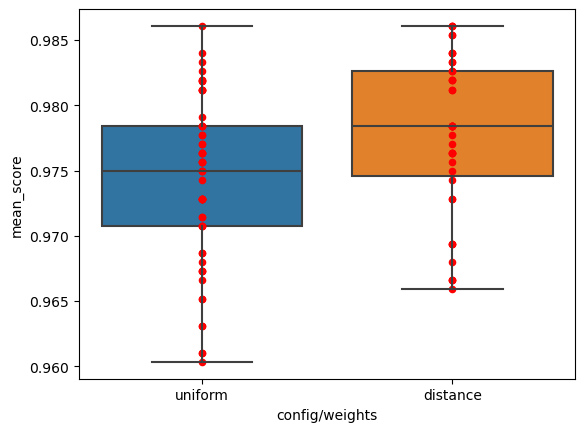

In [ ]:
#| fig-cap: "uniform与distance方法平均准确率箱线图对比"
#| fig-alt: "每一个红点是一次实验结果，平均准确率是每一次实验中五折交叉验证的平均值。"
fig, ax = plt.subplots()
sns.boxplot(data=dfi, x='config/weights', y='mean_score', ax=ax)
dfi.plot(x='config/weights', y='mean_score', ax=ax, kind='scatter', c='red')

以上的结果并没有控制变量，是直接进行了一个统计。相关性不代表因果性，所以上面的结果仅仅代表了在我们调参采样过程中，自变量“weights”与因变量“mean_score”的一定的相关性。
如果我们不知道每一次实验具体的其他的无关变量，上面的图我们也可以做一个合理的假设检验（验证我们的实验假设的零假设是否要拒绝！）。

根据论文[@Demšar_2006]，在机器学习中应该使用mann-whitney U检验和Wilcoxon signed-rank检验，因为这两个检验对样本的分布没有假定，而其他的一些检验比如t检验不太适用与样本分布不符合假设分布的情况。其中对于 “不知道每一次实验的其他无关变量是什么”的情况，也就是说自变量取“distance”和“uniform”得到的两列样本是独立（independent）的时候，应当使用mann-whitney U检验。

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
grouped = dfi.groupby('config/weights')
group_mean_scores = {name:group['mean_score'] for name, group in grouped}
scores_for_distance = group_mean_scores['distance']
scores_for_uniform = group_mean_scores['uniform']
u, p = mannwhitneyu(scores_for_distance, scores_for_uniform, 
                    alternative='greater' # 实验备则假设，distance 方法更好
                    )
if p < 0.05:
    print("Reject null hypothesis! `distance` is significantly better than `uniform`")

Reject null hypothesis! `distance` is significantly better than `uniform`


刚才我们只是整体分析。
接下来我们要寻找控制其他变量最优时，两个方法各自最优的参数是什么？以及这两个方法对哪些超参数比较敏感？

我们先回答第一个问题，我们从刚才的表格筛选一下。

In [ ]:
max_rows = dfi.loc[df.groupby('config/weights')['mean_score'].idxmax()]
max_rows

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,config/weights,config/n_neighbors,config/distance_metric
3,0.98608,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,distance,1,euclidean
36,0.98608,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,uniform,1,l2


这里我们可以对5次实验的结果进行统计分析，由于这五次实验是相关的，即这五次实验每一次用的同一个fold去训练，所以这里我们不应当用mann-whitney U检验，这一次我们要用Wilcoxon signed-rank检验。

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
#| hide
[v for k, v in max_rows.iloc[0].to_dict().items() if k.startswith('score_')]

[0.9861111111111112,
 0.9895833333333334,
 0.9825783972125436,
 0.9825783972125436,
 0.9895470383275261]

In [ ]:

scores_for_distance = [v for k, v in max_rows.iloc[0].to_dict().items() if k.startswith('score_')]
scores_for_uniform = [v for k, v in max_rows.iloc[1].to_dict().items() if k.startswith('score_')]
u, p = wilcoxon(scores_for_distance, scores_for_uniform, 
                zero_method='zsplit',
                    alternative='greater' # 实验备则假设，distance 方法更好
                    )
if p> 0.05:
    print("Null hypothesis cannot be rejected, so I have to accept it. ")

Null hypothesis cannot be rejected, so I have to accept it. 


/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


原来，当我们控制无关变量最优时，两个方法的性能能达到一致。具体来说，这里种找到的最优超参数正好是让knn的k为1，所以这个情况下distance方法和n_neighbors方法没有区别。按照谷歌调参手册的科研方法，对于这个数据集来说就无法说明这两个方法的优劣了。

然而，我个人认为，一个方法之所以被学术界认为有价值，在于这个方法能被其他人follow和cite。什么样的方法能对其他人的工作有帮助，什么样的方法就有价值。形式化一点来说，对 “其他人的工作”这个随机分布而言，我们的方法“应用上去之后，比不应用我们的方法或者使用其他方法更好”这个随机变量的期望值就是我们做科研应该追求的价值。

需要注意的是，“其他人的工作”由于他们计算资源以及研究者认知的局限，是比较不可能为你的方法调整整个实验流程其他的元参数或者说无关变量的。换句话说，如果你的方法需要其他人为你的方法来调参才能表现良好，那么你的方法的价值其实也是比较有限的。

在这里我们就遇到这个情况，在大部分随机的无关变量上，我们看到假设检验拒绝了零假设，说明distance方法期望地来说是对其他研究人员有帮助的，然而当调参到最优时，他们又都能达到最好。


现在我们回答第二个问题，这两个方法分别对其他元参数的敏感性如何?
首先分析对n_neighbors的敏感性。这个是通过quasi random search采样的。

In [ ]:
import copy

In [ ]:
#| export
# 为了解决seaborn开发者不愿意支持用户看到拟合曲线参数的问题，我们查找到了下面的解决方案
# 本代码参考 https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn
def regplot(
    *args,
    line_kws=None,
    marker=None,
    scatter_kws=None,
    **kwargs
):
    # this is the class that `sns.regplot` uses
    plotter = sns.regression._RegressionPlotter(*args, **kwargs)

    # this is essentially the code from `sns.regplot`
    ax = kwargs.get("ax", None)
    if ax is None:
        ax = plt.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)

    plotter.plot(ax, scatter_kws, line_kws)

    # unfortunately the regression results aren't stored, so we rerun
    grid, yhat, err_bands = plotter.fit_regression(plt.gca())

    # also unfortunately, this doesn't return the parameters, so we infer them
    slope = (yhat[-1] - yhat[0]) / (grid[-1] - grid[0])
    intercept = yhat[0] - slope * grid[0]
    return slope, intercept

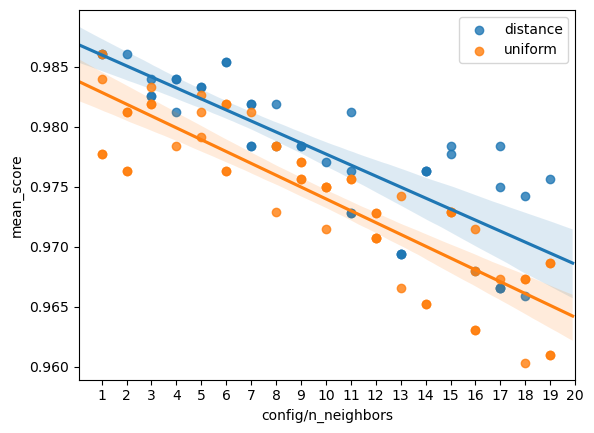

For distance, the regression line is y = -9.18e-04x + 9.87e-01
For uniform, the regression line is y = -9.86e-04x + 9.84e-01


In [ ]:
#| label: fig-n_neighbors
#| fig-cap: "Relationship between n_neighbors and mean_score"
#| fig-alt: "在图中我们画出了拟合的直线以及之前的95%置信区间。"
f = plt.figure()
ax = f.add_subplot(1,1,1)
line_dict = {}
for name, group in grouped:
    # plt.scatter(group['config/n_neighbors'], group['mean_score'], label=name)
    # p = sns.regplot(x='config/n_neighbors', y='mean_score', data=dfi, fit_reg=True, ax=ax)
    k, b = regplot(x='config/n_neighbors', y='mean_score', data=group, label=name, fit_reg=True)
    line_dict[name] = (k, b)
    

# sns.lmplot(x='config/n_neighbors', y='mean_score', data=dfi, hue="config/weights", fit_reg=True)
# 使用整数x坐标轴
plt.xticks(range(1, 21))
# plt.xlabel('n_neighbors')
# plt.ylabel('mean_score')
plt.legend()
# plt.title("Relationship between n_neighbors and mean_score")
plt.show()
# p.get_lines()[0].get_xdata(), p.get_lines()[0].get_ydata()
for name, (k, b) in line_dict.items():
    print(f"For {name}, the regression line is y = {k:.2e}x + {b:.2e}")

从图 @fig-n_neighbors 中可以看出，在数字识别问题上，无论是distance方法还是uniform方法，都是neighbors数量越多，精度反而越低。

从斜率上来看可能会以为这个问题很小，只是稍微减少了精度，但是从视觉上好像确实下降地很明显。我们为了从统计上说明清楚到底下降地显不显著，可以进一步通过皮尔森相关系数以及斯皮尔曼相关系数对应的假设检验来验证这个问题。

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
def test_correlation_with(x, y, data, test_func, alpha=0.05):
    correlation, p_value = test_func(data[x], data[y])
    print(f"{test_func.__name__}  correlation coefficient: between {x} and {y}: {correlation}, p-value: {p_value}")
    if p_value < alpha:
        print("The correlation is significant!")
    else:
        print("The correlation is not significant.")

test_correlation_with('config/n_neighbors', 'mean_score', dfi, pearsonr)
test_correlation_with('config/n_neighbors', 'mean_score', dfi, spearmanr)

pearsonr  correlation coefficient: between config/n_neighbors and mean_score: -0.8148057329177487, p-value: 6.1435506488484e-25
The correlation is significant!
spearmanr  correlation coefficient: between config/n_neighbors and mean_score: -0.8085147488740115, p-value: 2.6833127946483235e-24
The correlation is significant!


### 附加任务: 尝试使⽤不同的策略来构建 KD 树，使得在分类阶段可以有更快的分类效率

注意我们这里探索要修改的目标是构建 KD 树的过程，也就是要改变KD树的结构，而不是修改KNN分类算法，主要也不是修改KD树的搜索算法。
这里我们的目标是让搜索的效率更高。


文献@KD-means中总结了KD树构造时的一些常见策略，其中最重要的就是splitting method。分割一个父节点的时候，我们需要决定1. 在哪个数据维度（𝑠𝑑）上进行划分 2. 这个维度上哪个值作为划分点。对于第一点，作者选择范围最广的维度（𝑚𝑎𝑥 − 𝑚𝑖𝑛）来进行划分。

对于第二点，作者选择了滑动中点分割规则，因为它比其他经典规则提供了更优化的数据组织。这种规则不会产生空节点或数据空间非常稀疏的节点。与选择中位数作为切割值的经典规则不同，滑动中点分割规则选择点的中间值（（最大值𝑚𝑎𝑥 + 最小值𝑚𝑖𝑛）/ 2），这样做成本更低。

作者还提到KD树的构建过程中可以限制KD树的深度。但是我不太懂如果限制了深度，不是叶子节点的地方在搜索时应该如何处理，退化为暴力吗？

在我们实现新的算法之前，我们首先测试一下没改进之前的算法的速度。

In [ ]:
#| eval: false
%timeit y_pred = knn_classifier(X_train, y_train, X_test, k_neighbors)

5.07 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


现在我们来实现更快的KD树。

In [ ]:
# 复用上面的一些定义
Node, euclidean_distance

(__main__.Node, <function __main__.euclidean_distance(x1, x2)>)

In [ ]:
#| export
from typing import Callable

In [ ]:
#| export
verbose = False
def fast_build_kd_tree(X, axis_order_list:list, strategy = "median", depth=0):
    if len(X) == 0:
        return None
    k = X.shape[1]
    # 根据当前深度，选择划分的维度
    # 原本是 
    # axis = depth % k 
    # axis = axis_order(depth, k)
    assert len(axis_order_list)==k, f"axis_order_list length should be equal to k, but got {len(axis_order_list)} with {axis_order_list}"
    axis = axis_order_list[depth % k]
    if verbose:
        print(" "*4*depth + f"Building kd-tree of depth {depth} with {len(X)} points, axis is {axis}")
    
    # 中位数策略
    if strategy == "median":
        X = X[X[:, axis].argsort()]
        median = X.shape[0] // 2 #将当前结点数据一分为二
        # assert len(np.where((X_train == X[median]).all(axis=1)))>0
        return Node(data=X[median], left=fast_build_kd_tree(X[:median], axis_order_list, strategy, depth + 1),
                    right=fast_build_kd_tree(X[median + 1:],axis_order_list, strategy,  depth + 1))
    
    # 中点策略
    else:
        x_axis = X[:, axis] # n个数
        middle_point_value = (x_axis.max()-x_axis.min()) / 2
        left_points = X[x_axis <= middle_point_value]
        right_points = X[x_axis > middle_point_value]
        distances_on_axis_to_middle = abs(x_axis - middle_point_value)
        closest_point_to_middle = distances_on_axis_to_middle.argmin()
        
        return Node(data=X[closest_point_to_middle], left=fast_build_kd_tree(left_points, axis_order_list,strategy, depth + 1), right=fast_build_kd_tree(right_points, axis_order_list, strategy, depth + 1))
    

In [ ]:
#| export
from queue import PriorityQueue

In [ ]:
#| export
def fast_search_kd_tree(tree, target, axis_order_list:list, k=3):
    if tree is None:
        return []
    # k_nearest = [] #list用于储存target当前遍历到的k个k近邻
    # 我们使用优先队列来储存k_nearest，从而提高效率，优先队列中的元素为(-距离, 节点)的元组，距离远的先取出来
    # k_nearest_pq = PriorityQueue(maxsize=k)
    k_nearest_pq = PriorityQueue()
    entry_count = 0
    stack = [(tree, 0)] #用于储存待遍历节点的stack
    while stack:
        node, depth = stack.pop() # 节点出栈
        if node is None:
            continue
        # print(" "*4*depth + f"node: {node.data}, depth: {depth}")
        distance = euclidean_distance(target, node.data) #计算需要分类的目标点与节点的距离
        
        # 调换到前面
        axis = depth % target.shape[0] #计算当前深度对应的划分维度
        axis = axis_order_list[axis] # 新增加
        # print(axis)
        
        axis_diff = target[axis] - node.data[axis] #计算该维度下目标点与当前节点的差
        
        #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则另一边的子树也入栈
        can_omit_another_side = True
        # if len(k_nearest) < k: # 当k_nearest未装满时，直接将节点放入
        # if k_nearest.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        if k_nearest_pq.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        # if not k_nearest_pq.full(): # 当k_nearest未装满时，直接将节点放入
            # print(f"not full, put {(-distance, node)}")
            pass #BLANK_1
            # k_nearest.append((node, distance))
            k_nearest_pq.put((-distance, entry_count, node))
            entry_count+=1
            can_omit_another_side = False
        else: #当k_nearest装满时，对比该节点与k_nearest中与目标点距离最远的节点的距离，如果小于则替换，如果大于则不替换
            pass #BLANK_2
            farthest = k_nearest_pq.get()
            farthest_distance = -farthest[0]
            # print(f"full, farthest: {farthest}")
            if distance < farthest_distance:
                # print(f"closer, put {(-distance, node)}")
                # assert isinstance(distance, float)
                # print(k_nearest_pq.queue)
                k_nearest_pq.put((-distance, entry_count, node))
                entry_count+=1
            else:
                k_nearest_pq.put(farthest)
            

            if farthest_distance > abs(axis_diff): 
                can_omit_another_side = False
        
        if axis_diff <= 0: #当差小于0时则，该节点的左子树入栈 #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则右子树也入栈
            pass #BLANK_3
            stack.append((node.left, depth+1))
            if not can_omit_another_side:
                stack.append((node.right, depth+1))
        else:#当差大于0时则，该节点的右子树入栈，#如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则左子树也入栈
            pass #BLANK_4
            stack.append((node.right, depth+1))
            if not can_omit_another_side:
                stack.append((node.left, depth+1))
    # return [data for data, _ in k_nearest] #返回遍历完的kd树后的k_nearest
    # return [data for _, data in k_nearest] #返回遍历完的kd树后的k_nearest
    return [k_nearest_pq.get()[-1].data for i in range(k_nearest_pq.qsize())] #返回遍历完的kd树后的k_nearest

In [ ]:
#| export
# 由于我们需要记录axis_order， 所以要写成类
class FastKDTree:
    def __init__(self, X, split_value_strategy='median', axis_order_strategy='range') -> None:
        n, k = X.shape
        # 决定一下划分维度的顺序
        # 方差最大原则
        if axis_order_strategy == 'variance':
            self.axis_order_list = np.argsort(np.var(X, axis=0))
        # 极差最大原则
        elif axis_order_strategy == 'range':
            self.axis_order_list = np.argsort(np.max(X, axis=0) - np.min(X, axis=0))
        else:
            self.axis_order_list = np.arange(k)
        print(self.axis_order_list)
        self.root = fast_build_kd_tree(X, self.axis_order_list, split_value_strategy, 0)
    def search_kd_tree(self, point, k):
        return fast_search_kd_tree(self.root, point, self.axis_order_list, k)
    
    # 使用KNN算法分类
    def knn_classifier(self, X_train, y_train, X_test, k=3):
        y_pred = []
        for i, test_point in enumerate(X_test):
            k_nearest = self.search_kd_tree(test_point, k)
            # print(k_nearest)
            # print(k_nearest[0])
            # print(np.where((X_train == k_nearest[0]).all(axis=1)))
            labels = [y_train[np.where((X_train == point).all(axis=1))[0][0]] for point in k_nearest]
            counts = np.bincount(labels)#计算k_nearest中样本最多的标签，预测目标样本为该标签
            y_pred.append(np.argmax(counts))
        return y_pred
try:
    tree = FastKDTree(X_train, split_value_strategy='middle')
except Exception as e:
    print(e)

[ 0 32 39 31 24 56 16  8 40 47 48 23  1 57 15 55 33 38  7  9 30 25 10  4
 14 13 12 11  6  5  3  2 28 29 26 27 19 20 21 22 17 18 42 41 36 37 35 34
 46 45 44 43 51 52 50 49 54 53 58 59 60 61 62 63]
maximum recursion depth exceeded while calling a Python object


我们发现如果是用middle策略，由于数字识别数据集的分布特性，中点能划分的点太少，无法成功建树。

In [ ]:
# tree = FastKDTree(X, split_value_strategy="median")
tree = FastKDTree(X_train, split_value_strategy="median")

[ 0 32 39 31 24 56 16  8 40 47 48 23  1 57 15 55 33 38  7  9 30 25 10  4
 14 13 12 11  6  5  3  2 28 29 26 27 19 20 21 22 17 18 42 41 36 37 35 34
 46 45 44 43 51 52 50 49 54 53 58 59 60 61 62 63]


In [ ]:
for i in range(len(X_train)):
    k_nearest = tree.search_kd_tree(X_train[0], 1)
    where = np.where((X_train == k_nearest[0]).all(axis=1))
    where = where[0]
    assert len(where) == 1

In [ ]:
# k_nearest = tree.search_kd_tree(X_test[0], 2)
# k_nearest = tree.search_kd_tree(X_train[0], 2)
# k_nearest, X_train[0]
# k_nearest = tree.search_kd_tree(X_test[0], 2)
# k_nearest
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

0.9861111111111112

In [ ]:
#| eval: false
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

5.15 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


我们发现速度变慢了！
如果使用方差最大策略呢？会不会更好？

In [ ]:
tree = FastKDTree(X_train, split_value_strategy="median", axis_order_strategy='variance')
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

[ 0 32 39 56 24 16 31  8 40 48 47 23 15  1 57 55  7 63 49 41 25  9 22  6
 33 17 38 14 30 11 62  3 46  4 59  2 12 54 60 58 51 52 10 45 50  5 18 19
 37 29 61 36 27 53 13 28 26 20 21 35 34 44 43 42]


0.9861111111111112

In [ ]:
#| eval: false
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

5.5 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


甚至更慢！为了避免是因为我们实现新的方法有一定的overhead，我们对原本的划分策略也做一次测速。

In [ ]:
#| eval: false
tree = FastKDTree(X_train, split_value_strategy="median", axis_order_strategy='simple')
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
5.37 s ± 310 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

0.9861111111111112

根据以上结果，我们初步得出结论，range划分方法比simple方法快，而simple方法比variance方法快。